## Env

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
import xgboost as xgb

from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor

| 항목 | 설명     |
|-----|----------|
| X1  | 작업번호 |
| X2  | 마킹길이 |
| X3  | 절단길이 |
| X4  | 철판두께 |
| X5  | 철판재질 |
| X6  | 절단갯수 |
| X7  | 작업장   |
| X8  | 작업자   |
| Y1  | 마킹시간 |
| Y2  | 절단시간 |


In [2]:
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
train = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\train.csv')
test = pd.read_csv(r'C:\Users\dlwks\OneDrive\바탕 화면\VSCode\HD_CNC\test.csv')

display(train.head())
display(test.head())

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,134764,56.3,67.5,22.5,AH32,4,97,PL973,467,2241
1,9854,115.0,67.0,13.0,AH32,2,27,PL271,1058,1163
2,94365,59.2,44.6,18.0,AH32-TM,1,14,PL141,270,1094
3,110641,52.1,97.4,15.0,A,17,24,PL242,391,2604
4,100159,42.9,58.7,14.5,A,4,23,PL233,232,1564


,Id,X1,X2,X3,X4,X5,X6,X7,X8
0,0,158065,80.6,104.8,11.0,A,29,23,PL234
1,1,65927,141.8,34.2,17.5,A,2,91,PL911
2,2,117029,77.2,103.3,17.0,A,10,97,PL973
3,3,50866,95.5,131.0,18.0,A,2,23,PL234
4,4,151900,91.7,36.1,19.0,AH32,1,27,PL271


## Preprocessing

In [4]:
train = train.rename(columns = {
    'X1' : '작업번호',
    'X2' : '마킹길이',
    'X3' : '절단길이',
    'X4' : '철판두께',
    'X5' : '철판재질',
    'X6' : '절단갯수',
    'X7' : '작업장',
    'X8' : '작업자',
    'Y1' : '마킹시간',
    'Y2' : '절단시간'
})

test = test.rename(columns = {
    'X1' : '작업번호',
    'X2' : '마킹길이',
    'X3' : '절단길이',
    'X4' : '철판두께',
    'X5' : '철판재질',
    'X6' : '절단갯수',
    'X7' : '작업장',
    'X8' : '작업자'
})

In [5]:
train['철판재질'] = pd.factorize(train['철판재질'])[0]
train['작업자'] = pd.factorize(train['작업자'])[0]

test['철판재질'] = pd.factorize(test['철판재질'])[0]
test['작업자'] = pd.factorize(test['작업자'])[0]

In [6]:
display(train.info())
display(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121754 entries, 0 to 121753
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   작업번호    121754 non-null  int64  
 1   마킹길이    121754 non-null  float64
 2   절단길이    121754 non-null  float64
 3   철판두께    121754 non-null  float64
 4   철판재질    121754 non-null  int64  
 5   절단갯수    121754 non-null  int64  
 6   작업장     121754 non-null  int64  
 7   작업자     121754 non-null  int64  
 8   마킹시간    121754 non-null  int64  
 9   절단시간    121754 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 9.3 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40571 entries, 0 to 40570
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      40571 non-null  int64  
 1   작업번호    40571 non-null  int64  
 2   마킹길이    40571 non-null  float64
 3   절단길이    40571 non-null  float64
 4   철판두께    40571 non-null  float64
 5   철판재질    40571 non-null  int64  
 6   절단갯수    40571 non-null  int64  
 7   작업장     40571 non-null  int64  
 8   작업자     40571 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 2.8 MB


None

In [7]:
train.head()

,작업번호,마킹길이,절단길이,철판두께,철판재질,절단갯수,작업장,작업자,마킹시간,절단시간
0,134764,56.3,67.5,22.5,0,4,97,0,467,2241
1,9854,115.0,67.0,13.0,0,2,27,1,1058,1163
2,94365,59.2,44.6,18.0,1,1,14,2,270,1094
3,110641,52.1,97.4,15.0,2,17,24,3,391,2604
4,100159,42.9,58.7,14.5,2,4,23,4,232,1564


In [8]:
display(train)

test.drop(columns = ['Id'], inplace = True)
display(test)

,작업번호,마킹길이,절단길이,철판두께,철판재질,절단갯수,작업장,작업자,마킹시간,절단시간
0,134764,56.3,67.5,22.5,0,4,97,0,467,2241
1,9854,115.0,67.0,13.0,0,2,27,1,1058,1163
2,94365,59.2,44.6,18.0,1,1,14,2,270,1094
3,110641,52.1,97.4,15.0,2,17,24,3,391,2604
4,100159,42.9,58.7,14.5,2,4,23,4,232,1564
...,...,...,...,...,...,...,...,...,...,...
121749,147050,98.4,89.5,10.0,76,8,21,9,906,1226
121750,151590,48.0,51.0,23.0,77,1,23,18,175,1540
121751,152421,42.5,30.2,34.0,78,5,27,22,376,1492
121752,161172,22.1,15.3,36.0,64,8,97,0,85,723


,작업번호,마킹길이,절단길이,철판두께,철판재질,절단갯수,작업장,작업자
0,158065,80.6,104.8,11.0,0,29,23,0
1,65927,141.8,34.2,17.5,0,2,91,1
2,117029,77.2,103.3,17.0,0,10,97,2
3,50866,95.5,131.0,18.0,0,2,23,0
4,151900,91.7,36.1,19.0,1,1,27,3
...,...,...,...,...,...,...,...,...
40566,112358,27.0,13.0,19.0,1,21,25,24
40567,150907,44.2,41.3,19.5,1,2,14,11
40568,57481,54.9,70.5,15.0,0,10,23,16
40569,48467,44.1,43.2,16.0,0,1,27,20


In [9]:
display(train.describe())
display(test.describe())

,작업번호,마킹길이,절단길이,철판두께,철판재질,절단갯수,작업장,작업자,마킹시간,절단시간
count,121754.000000,121754.000000,121754.000000,121754.000000,121754.000000,121754.000000,121754.000000,121754.000000,1.217540e+05,121754.000000
mean,81048.692675,77.608615,73.875636,17.444897,2.339816,13.630049,43.921152,13.363922,8.971671e+02,2193.206638
std,46870.157635,48.006125,53.267359,4.498316,4.120459,20.751914,32.509414,8.269139,4.604704e+04,2299.585390
min,1.000000,3.200000,1.800000,6.000000,0.000000,1.000000,14.000000,0.000000,0.000000e+00,0.000000
25%,40428.250000,45.200000,40.900000,14.500000,0.000000,1.000000,22.000000,6.000000,2.380000e+02,1064.000000
50%,81043.500000,68.100000,52.800000,17.000000,2.000000,4.000000,25.000000,12.000000,3.790000e+02,1593.000000
75%,121554.750000,98.300000,93.000000,20.000000,2.000000,18.000000,91.000000,21.000000,5.480000e+02,2778.000000
max,162341.000000,524.400000,621.300000,40.000000,78.000000,416.000000,97.000000,28.000000,6.157364e+06,348262.000000


,작업번호,마킹길이,절단길이,철판두께,철판재질,절단갯수,작업장,작업자
count,40571.000000,40571.000000,40571.000000,40571.000000,40571.000000,40571.000000,40571.000000,40571.000000
mean,81536.254122,78.408661,73.741996,17.488975,1.564837,13.451209,43.929161,12.575436
std,46845.236185,48.351212,53.069122,4.505772,3.556288,20.591742,32.503838,8.109459
min,4.000000,3.700000,1.100000,6.000000,0.000000,1.000000,14.000000,0.000000
25%,41100.500000,45.700000,41.000000,14.500000,0.000000,1.000000,22.000000,6.000000
50%,81500.000000,68.700000,52.500000,17.000000,1.000000,4.000000,25.000000,12.000000
75%,122412.500000,99.700000,92.700000,20.000000,1.000000,18.000000,91.000000,19.000000
max,162338.000000,445.300000,621.300000,36.000000,50.000000,262.000000,97.000000,28.000000


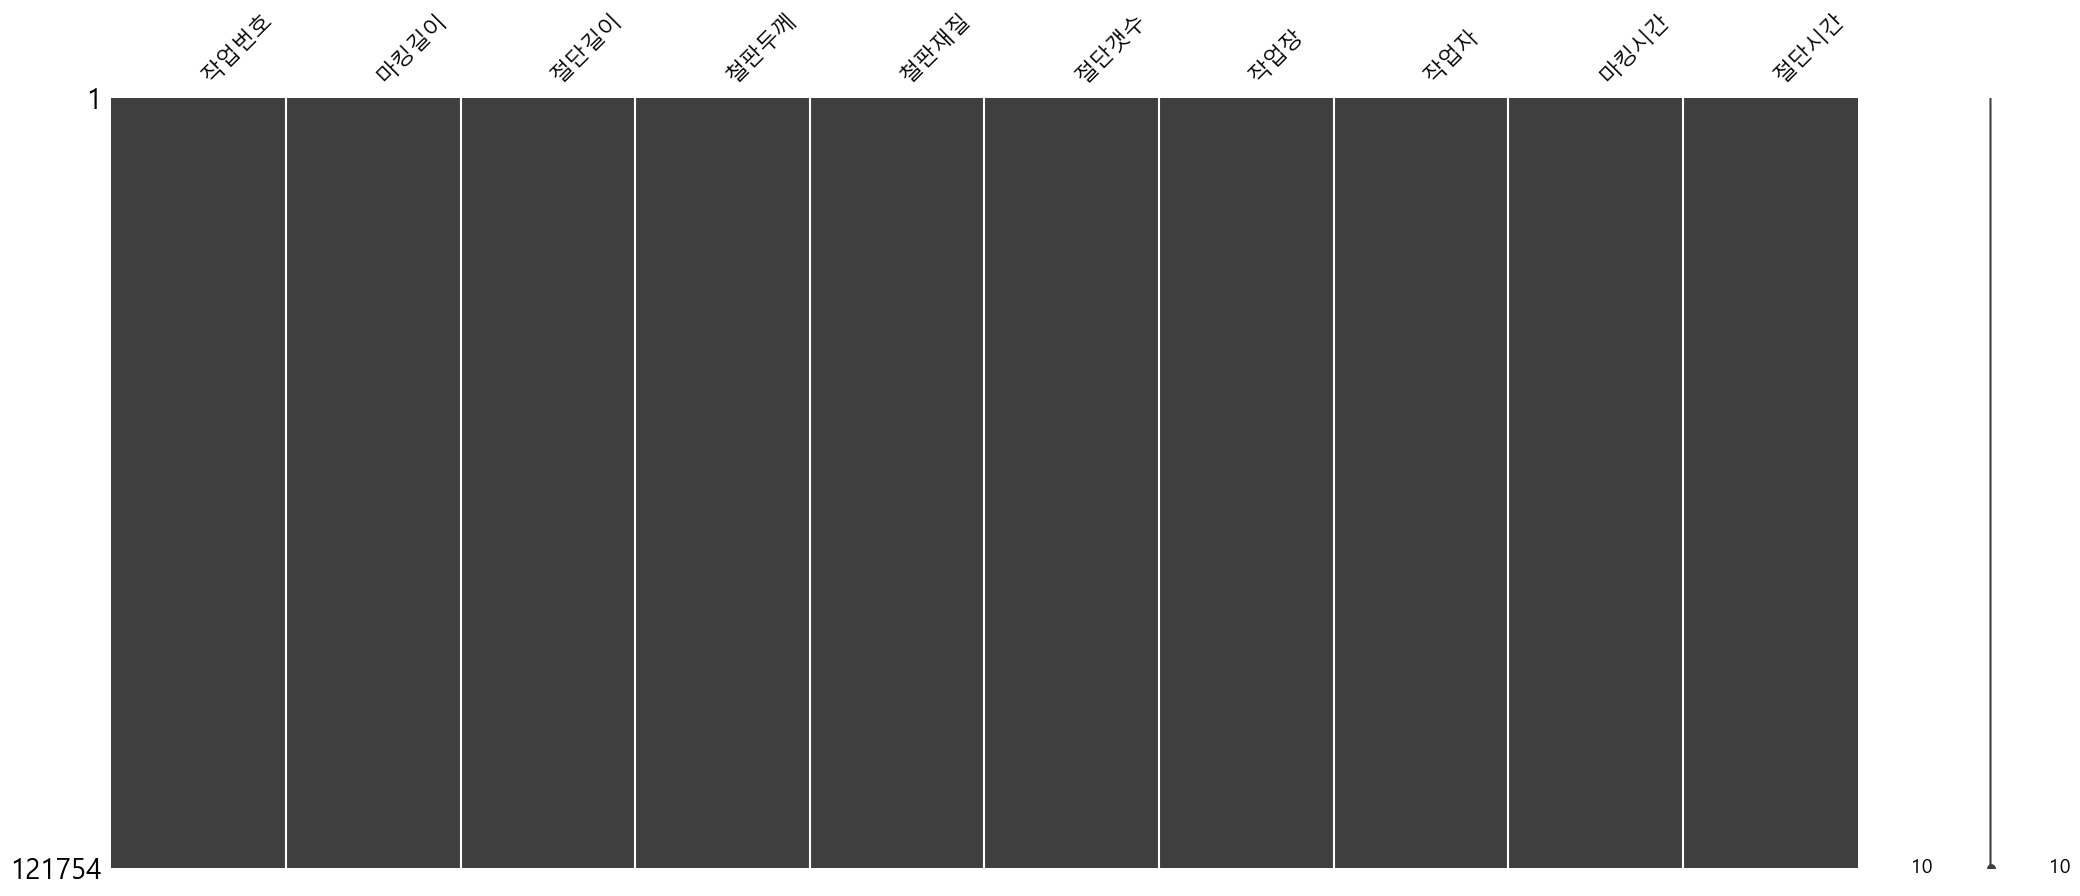

In [10]:
ms.matrix(train)
plt.show()

## EDA

<Axes: >

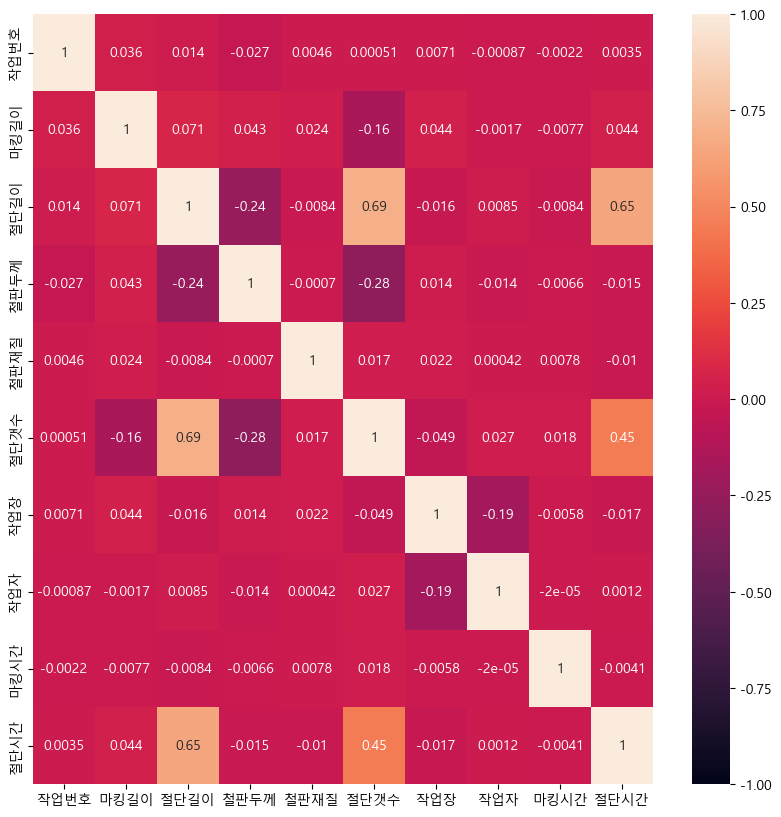

In [11]:
plt.figure(figsize = (10, 10))
sns.heatmap(train.corr(), vmax = 1, vmin = -1, annot = True)

c:\Users\dlwks\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


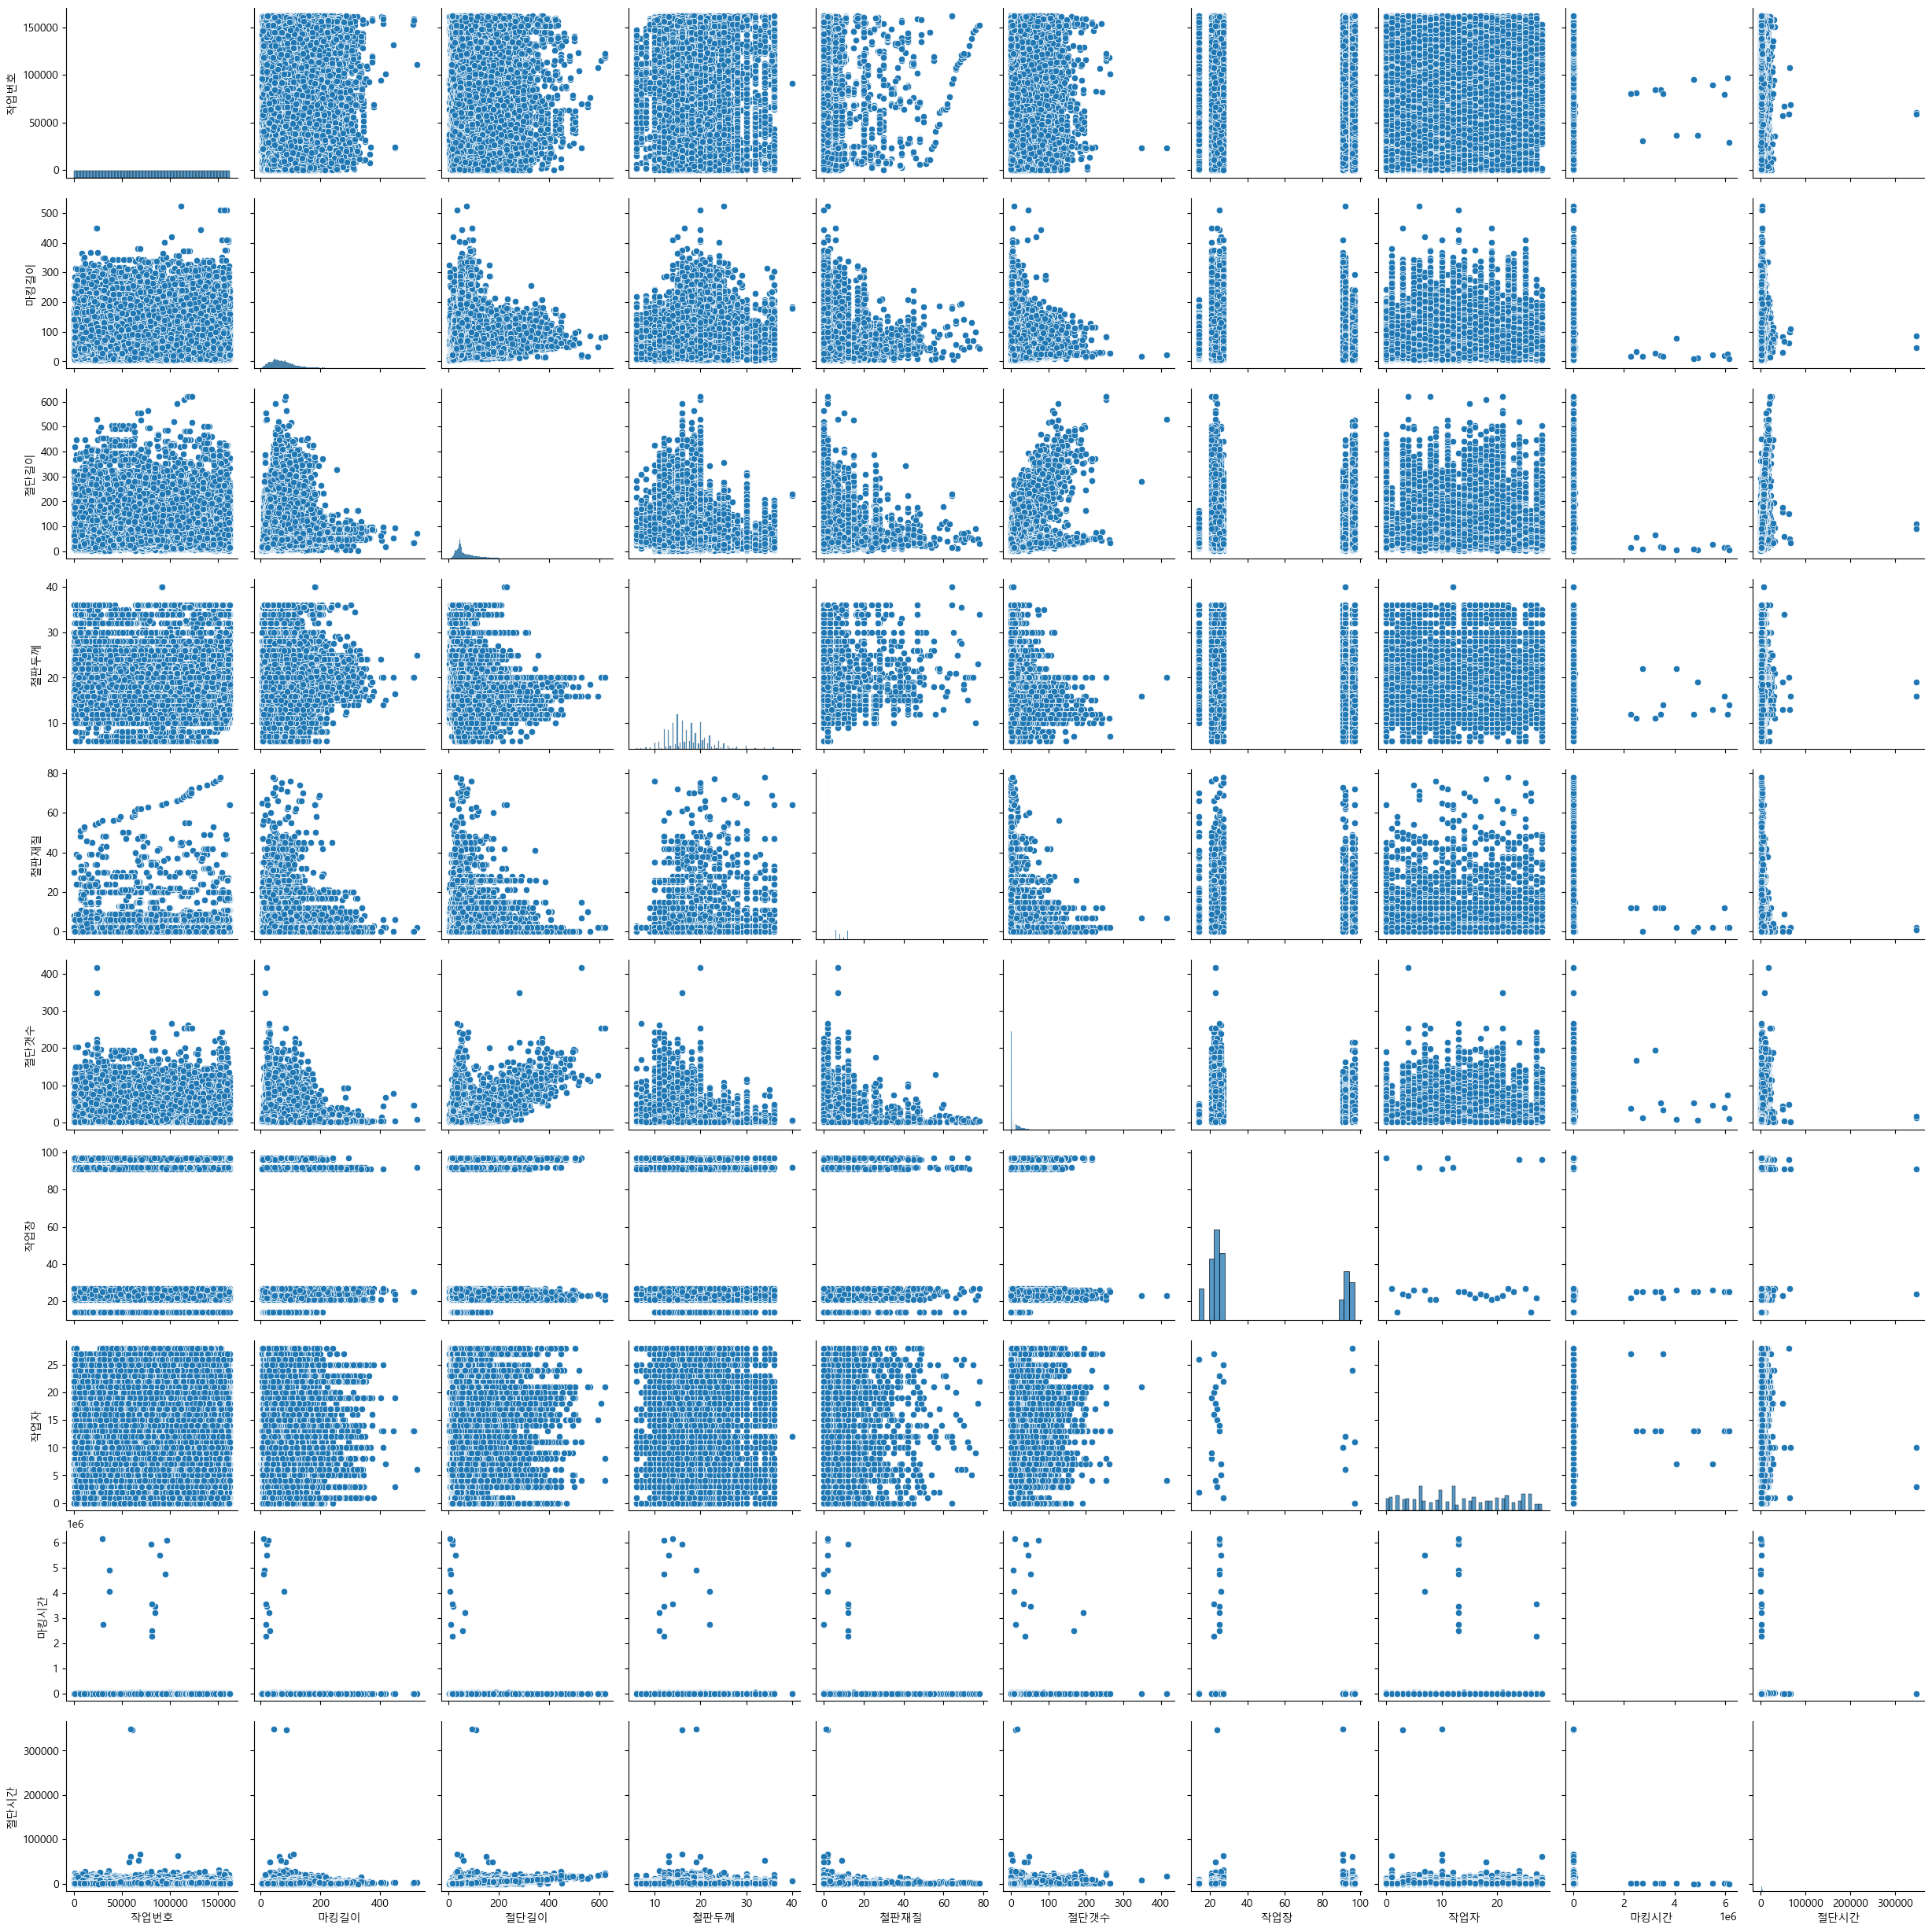

In [12]:
sns.pairplot(train)

<Figure size 1500x500 with 0 Axes>

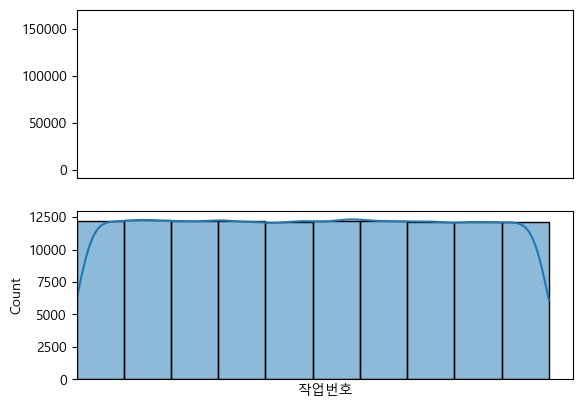

<Figure size 1500x500 with 0 Axes>

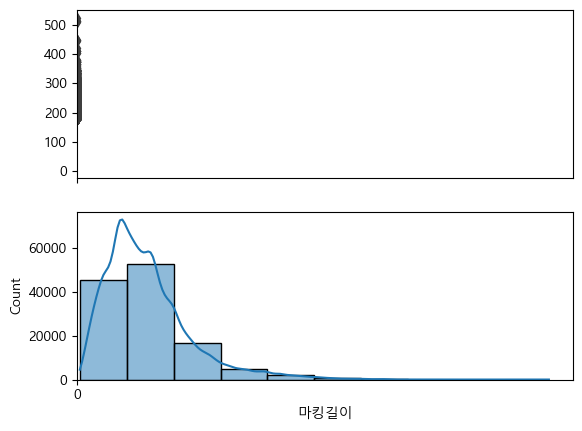

<Figure size 1500x500 with 0 Axes>

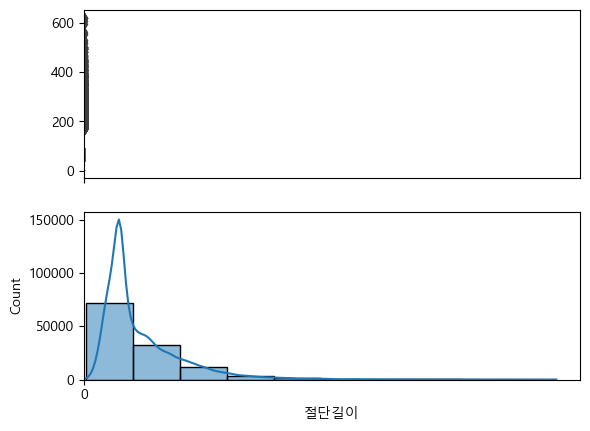

<Figure size 1500x500 with 0 Axes>

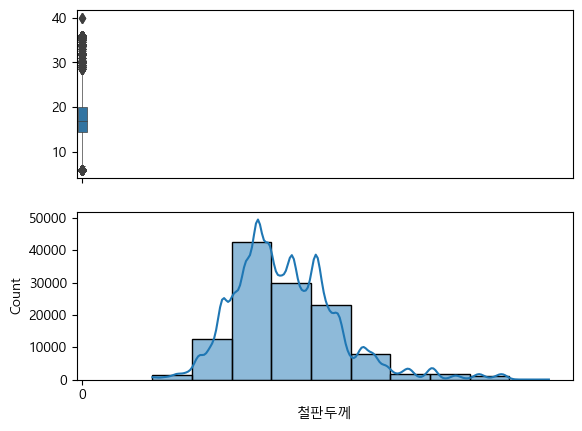

<Figure size 1500x500 with 0 Axes>

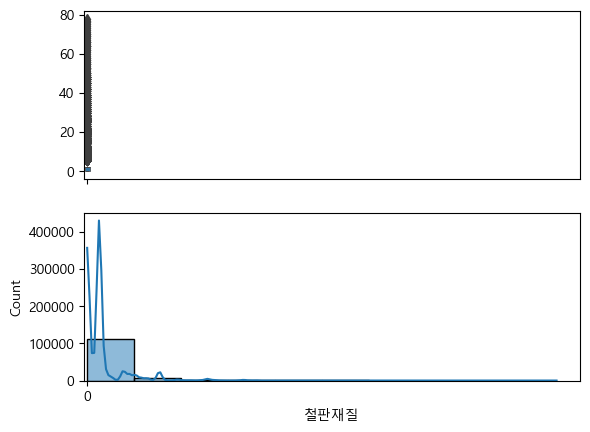

<Figure size 1500x500 with 0 Axes>

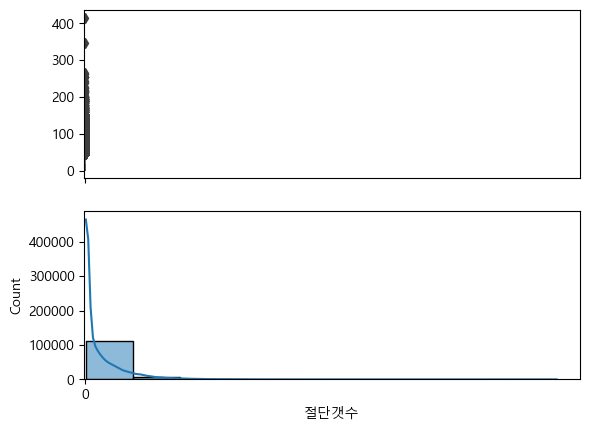

<Figure size 1500x500 with 0 Axes>

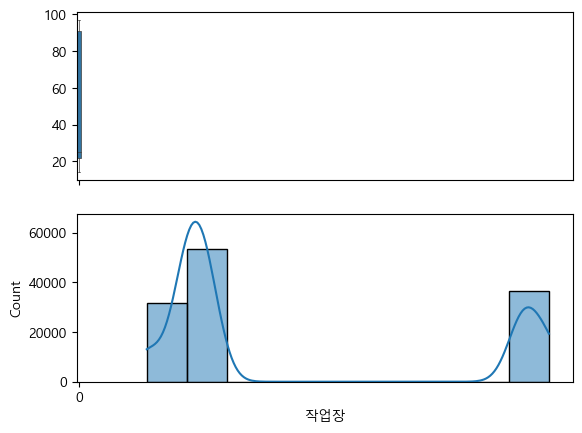

<Figure size 1500x500 with 0 Axes>

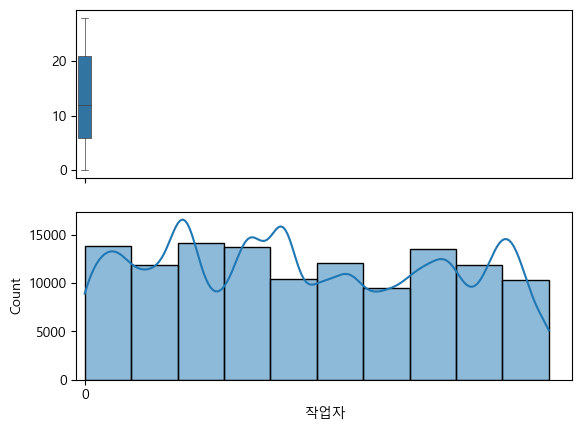

<Figure size 1500x500 with 0 Axes>

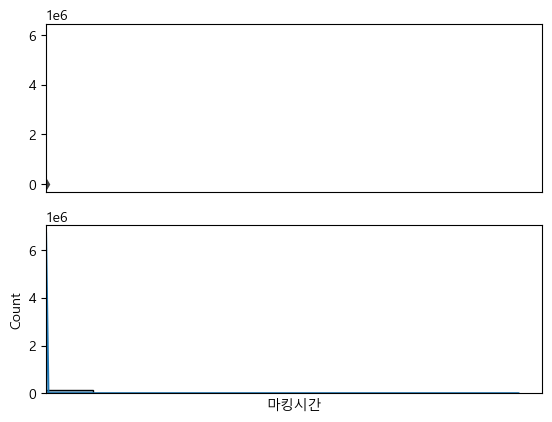

<Figure size 1500x500 with 0 Axes>

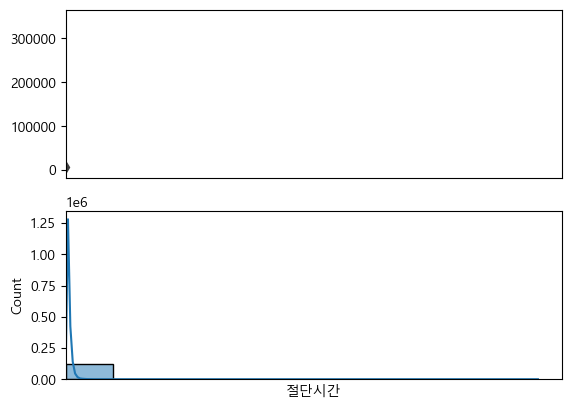

In [13]:
features = train.columns
numeric_features = train.select_dtypes('number').columns
categorical_features = train.select_dtypes('object').columns
for i in numeric_features:
  plt.figure(figsize = (15, 5))
  plt.tight_layout()
  f, (ax_box, ax_hist) = plt.subplots(2, sharex = True)
  sns.boxplot(train[i], ax = ax_box, linewidth = 0.5)
  sns.histplot(train[i], ax = ax_hist, bins = 10, kde = True)

numeric cols : 10
Index(['작업번호', '마킹길이', '절단길이', '철판두께', '철판재질', '절단갯수', '작업장', '작업자', '마킹시간',
       '절단시간'],
      dtype='object')


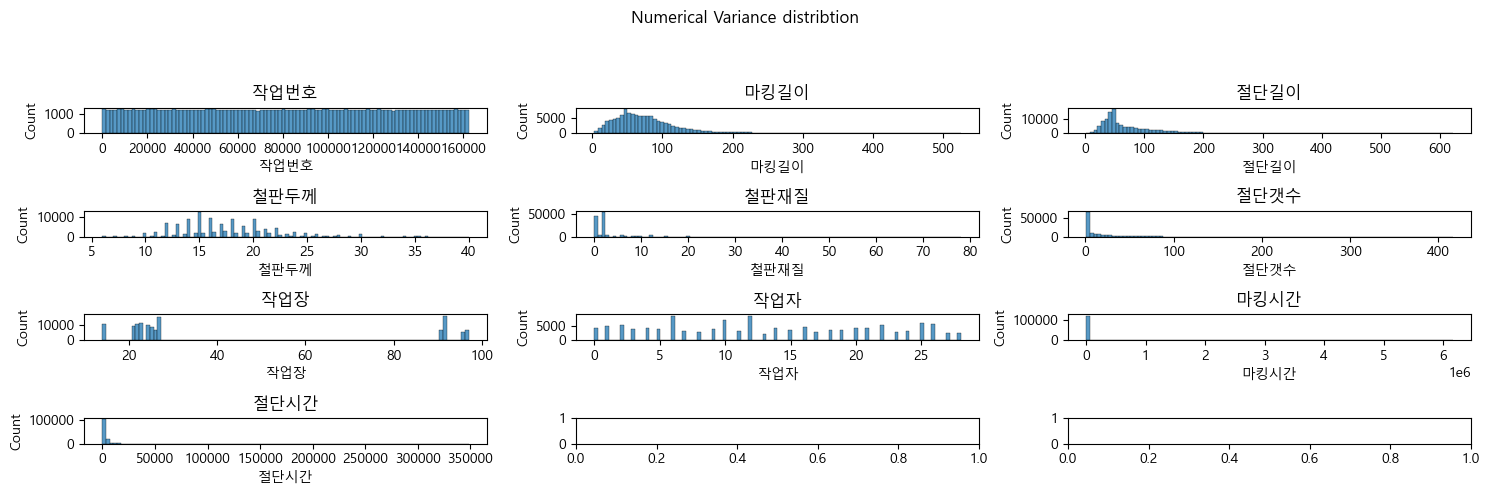

In [14]:
cols_numeric = train.describe().columns

print(f'numeric cols : {len(cols_numeric)}')
print(f'{cols_numeric}')

fig, ax = plt.subplots(4, 3, figsize=(15, 5))

for i in range(len(cols_numeric)):

    x = i // 3    
    y = i % 3
    
    sns.histplot(x=cols_numeric[i], data = train, bins=100, ax=ax[x,y])
    ax[x, y].set_title(cols_numeric[i])

plt.suptitle('Numerical Variance distribtion\n\n')
plt.tight_layout()
plt.show()

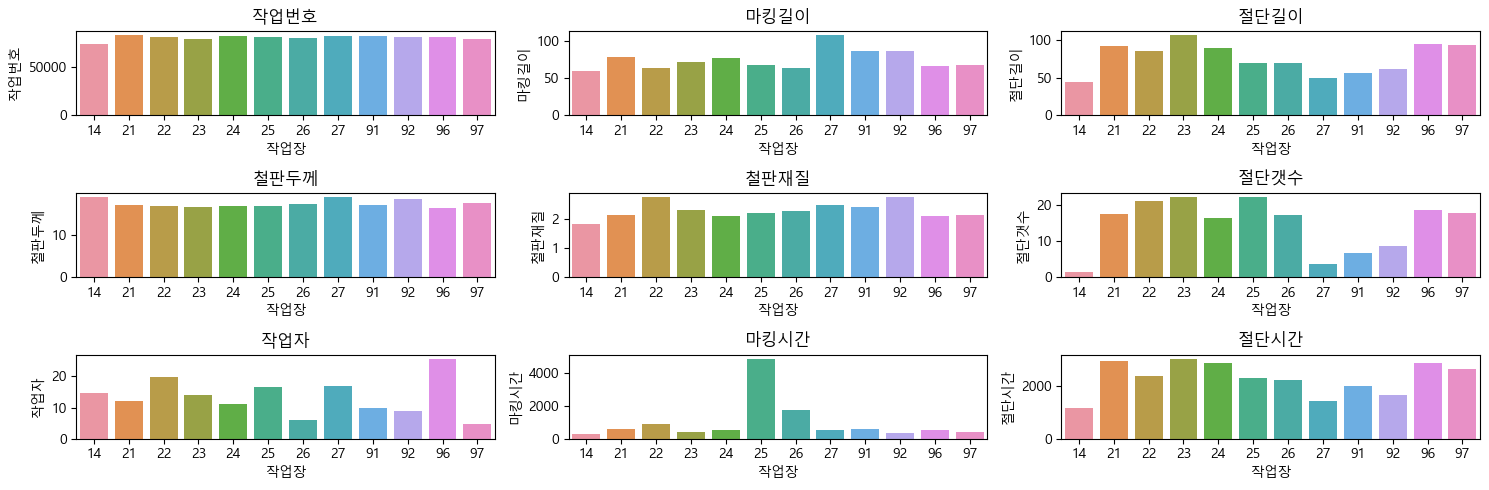

In [15]:
data = train.groupby('작업장').mean().reset_index()

fig, axes = plt.subplots(3, 3, figsize=(15, 5))

sns.barplot(x = '작업장', y = '작업번호', data = data, ax = axes[0, 0])
axes[0, 0].set_title('작업번호')

sns.barplot(x = '작업장', y = '마킹길이', data = data, ax = axes[0, 1])
axes[0, 1].set_title('마킹길이')

sns.barplot(x = '작업장', y = '절단길이', data = data, ax = axes[0, 2])
axes[0, 2].set_title('절단길이')

sns.barplot(x = '작업장', y = '철판두께', data = data, ax = axes[1, 0])
axes[1, 0].set_title('철판두께')

sns.barplot(x = '작업장', y = '철판재질', data = data, ax = axes[1, 1])
axes[1, 1].set_title('철판재질')

sns.barplot(x = '작업장', y = '절단갯수', data = data, ax = axes[1, 2])
axes[1, 2].set_title('절단갯수')

sns.barplot(x = '작업장', y = '작업자', data= data, ax= axes[2, 0])
axes[2, 0].set_title('작업자')

sns.barplot(x = '작업장', y = '마킹시간', data = data, ax = axes[2, 1])
axes[2, 1].set_title('마킹시간')

sns.barplot(x = '작업장', y = '절단시간', data = data, ax = axes[2, 2])
axes[2, 2].set_title('절단시간')

plt.tight_layout()
plt.show()

## 첨도, 왜도, 6시그마

In [16]:
# numeric_columns = train.select_dtypes(include=np.number).columns

# for var in numeric_columns:
#     skewness = skew(train[var])
#     kurt = kurtosis(train[var])
    
#     print(f' {var}의 왜도: {skewness}')
#     print(f' {var}의 첨도: {kurt}\n')

 작업번호의 왜도: 0.002526001389359533
 작업번호의 첨도: -1.1994096231932934

 마킹길이의 왜도: 1.5342480744471783
 마킹길이의 첨도: 3.6442037894546786

 절단길이의 왜도: 2.2075296710376824
 절단길이의 첨도: 7.438586381057563

 철판두께의 왜도: 0.9386827192407282
 철판두께의 첨도: 1.8334935914601536

 철판재질의 왜도: 5.119681304616308
 철판재질의 첨도: 42.392405906084065

 절단갯수의 왜도: 3.020271373124679
 절단갯수의 첨도: 14.246940911847457

 작업장의 왜도: 0.8491572732534536
 작업장의 첨도: -1.218014439443876

 작업자의 왜도: 0.09713242211582016
 작업자의 첨도: -1.2162359819822333

 마킹시간의 왜도: 109.34036985339624
 마킹시간의 첨도: 12603.309922710854

 절단시간의 왜도: 57.97279970958336
 절단시간의 첨도: 8419.479027113046



In [17]:
# for col in numeric_columns:
#     if (train[col] > 0).all():
#         transformed_data, lambda_value = stats.boxcox(train[col])
#         train[col] = transformed_data

#     else:
#         print(f"변수 '{col}'에 음수 값이 있습니다.")
#         train[col] = np.log1p(train[col])

# skewness = train[numeric_columns].skew()
# kurtosis = train[numeric_columns].kurtosis()
# print("각 변수의 왜도:")
# print(skewness)

# print("각 변수의 첨도:")
# print(kurtosis)

변수 '철판재질'에 음수 값이 있습니다.
변수 '작업자'에 음수 값이 있습니다.
변수 '마킹시간'에 음수 값이 있습니다.
변수 '절단시간'에 음수 값이 있습니다.
각 변수의 왜도:
작업번호   -0.291735
마킹길이    0.008332
절단길이   -0.006415
철판두께    0.003215
철판재질    0.695799
절단갯수    0.119422
작업장     0.206573
작업자    -1.120021
마킹시간   -3.183576
절단시간   -1.411988
dtype: float64
각 변수의 첨도:
작업번호    -1.003186
마킹길이     0.184736
절단길이     0.342033
철판두께     0.671703
철판재질     0.362745
절단갯수    -1.425055
작업장     -0.867345
작업자      0.683471
마킹시간    13.688865
절단시간    16.357298
dtype: float64


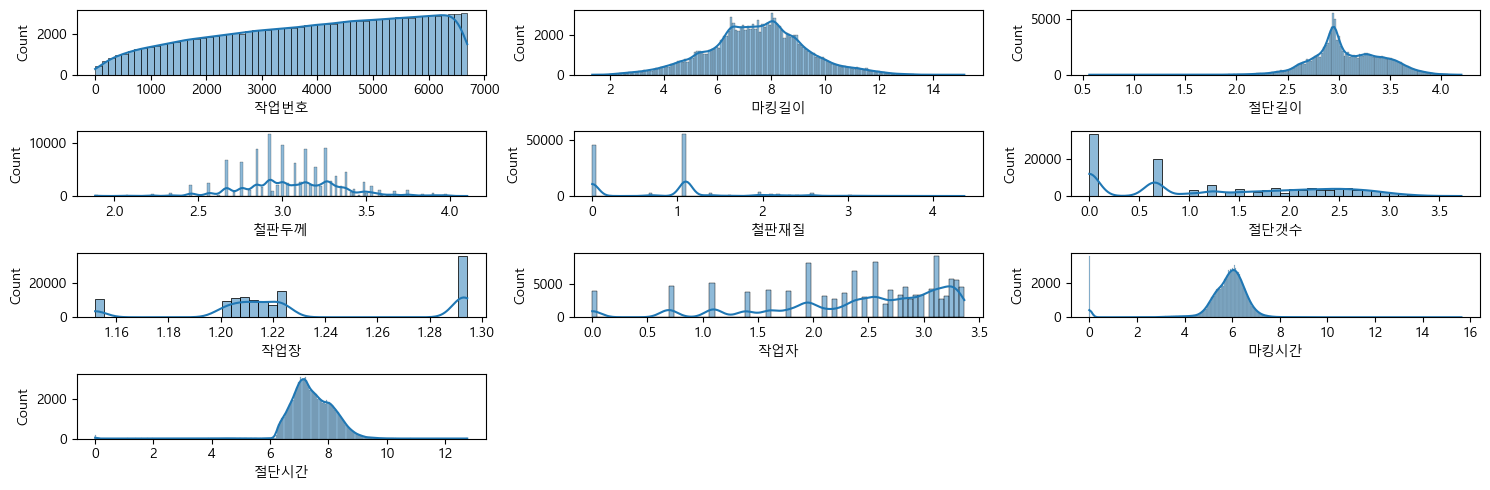

In [18]:
# columns_per_row = 3
# total_columns = len(numeric_columns)
# total_rows = (total_columns + columns_per_row - 1) // columns_per_row

# fig, axes = plt.subplots(total_rows, columns_per_row, figsize = (15, 5))

# for i, col in enumerate(numeric_columns):
#     row_idx = i // columns_per_row
#     col_idx = i % columns_per_row
#     sns.histplot(train[col], kde=True, ax=axes[row_idx, col_idx])

# for i in range(total_columns, total_rows * columns_per_row):
#     row_idx = i // columns_per_row
#     col_idx = i % columns_per_row
#     fig.delaxes(axes[row_idx, col_idx])

# plt.tight_layout()
# plt.show()

<Axes: >

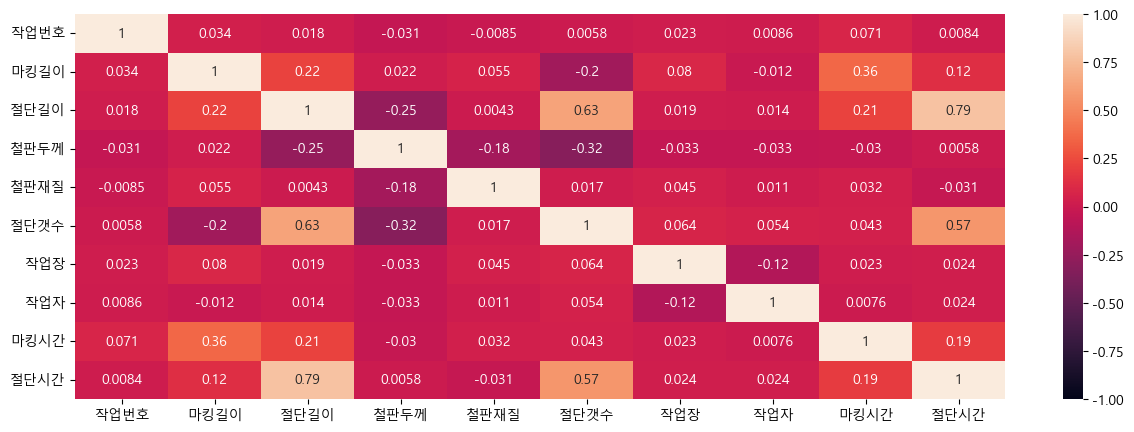

In [19]:
plt.figure(figsize = (15, 5))
sns.heatmap(train.corr(), vmin = -1, vmax = 1, annot = True)

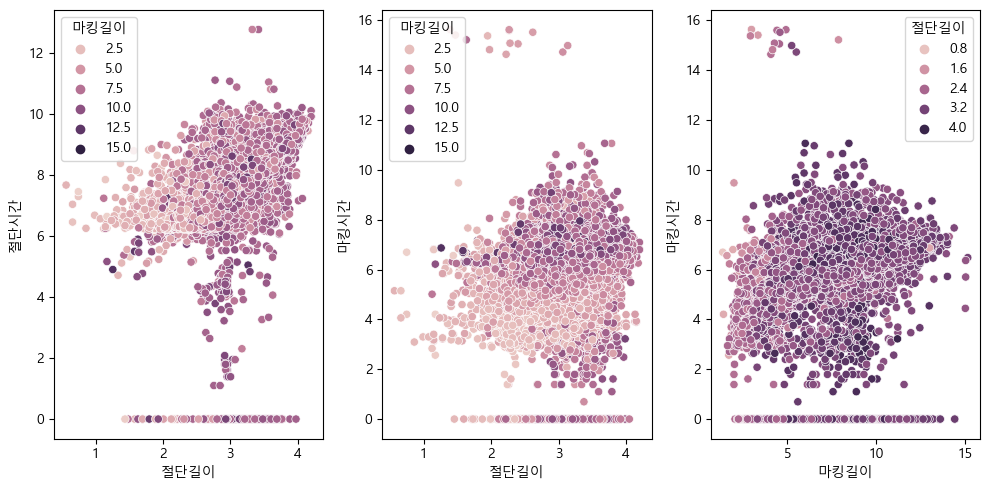

In [20]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x = '절단길이', y = '절단시간', hue = '마킹길이', data = train)

plt.subplot(1, 3, 2)
sns.scatterplot(x = '절단길이', y = '마킹시간', hue = '마킹길이', data = train)

plt.subplot(1, 3, 3)
sns.scatterplot(x = '마킹길이', y = '마킹시간', hue = '절단길이', data = train)

plt.tight_layout()
plt.show()

In [21]:
def remove_outliers(df, col_name):
    uppper_bound = df[col_name].mean() + 6 * df[col_name].std()
    lower_bound = df[col_name].mean() - 6 * df[col_name].std()

    print(f"평균: {df[col_name].mean()}, 표준편차: {df[col_name].std()}")

    return df[(df[col_name] < uppper_bound) & (df[col_name] > lower_bound)]

columns_to_process = ['마킹길이', '절단길이', '철판두께', '철판재질', '절단갯수', '작업장', '작업자', '마킹시간', '절단시간']

for col in columns_to_process:
    train = remove_outliers(train, col)

평균: 7.478657825824708, 표준편차: 1.7911938998139814
평균: 3.084484827536983, 표준편차: 0.3406561578628292
평균: 3.066638794306891, 표준편차: 0.29619218016380944
평균: 0.8428527207435687, 표준편차: 0.7792418207584687
평균: 1.2900329638253603, 표준편차: 1.0491060572866717
평균: 1.2318234750276456, 표준편차: 0.044005945938497944
평균: 2.40859117379667, 표준편차: 0.8313349718624067
평균: 5.737848880495292, 표준편차: 1.1975956138877848
평균: 7.444708406768045, 표준편차: 0.7287435312887827


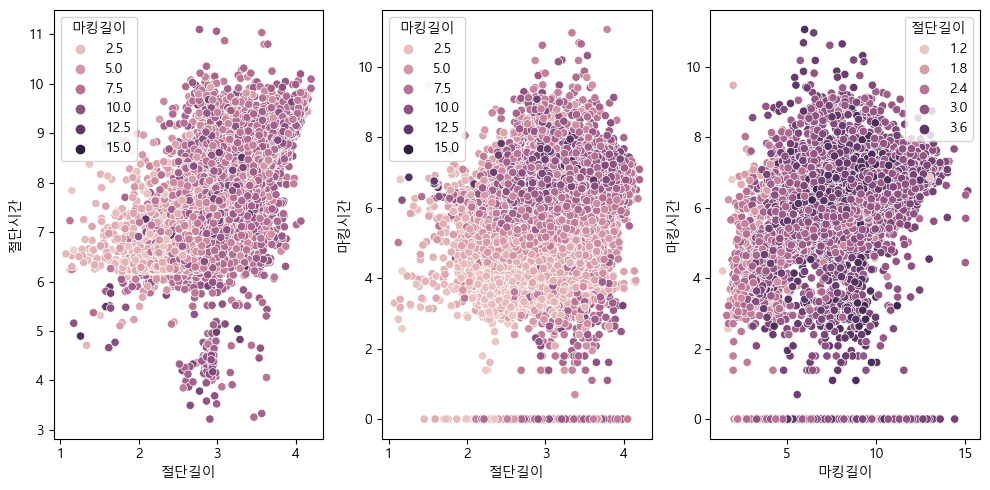

In [22]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x = '절단길이', y = '절단시간', hue = '마킹길이', data = train)

plt.subplot(1, 3, 2)
sns.scatterplot(x = '절단길이', y = '마킹시간', hue = '마킹길이', data = train)

plt.subplot(1, 3, 3)
sns.scatterplot(x = '마킹길이', y = '마킹시간', hue = '절단길이', data = train)

plt.tight_layout()
plt.show()

## 특성 중요도


Model Tune for XGB.


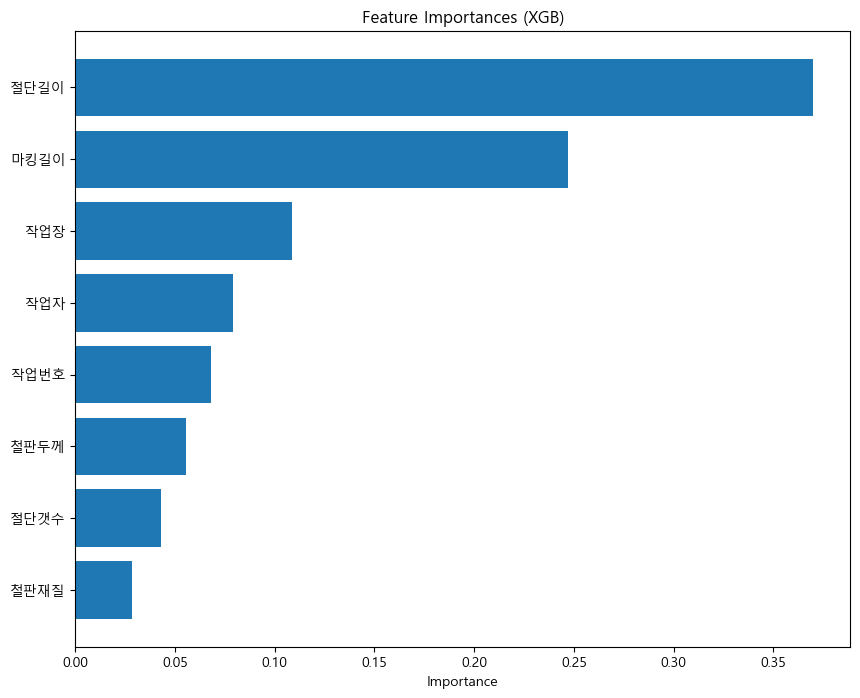

In [23]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

X_train = train.drop(columns = ['마킹시간', '절단시간'])
Y_train = train[['마킹시간', '절단시간']]

# Model Tune for XGB
xgb_model, xgb_feature_importances = train_and_evaluate(xgb.XGBRegressor(), 'XGB', X_train, Y_train)

In [24]:
scaler = StandardScaler()

# X_train = train.drop(columns = ['마킹시간', '절단시간'])
# Y_train = train[['마킹시간', '절단시간']]

X_test = test[X_train.columns]

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=['작업번호', '마킹길이', '절단길이', '철판두께', '철판재질', '절단갯수', '작업장', '작업자'])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=['작업번호', '마킹길이', '절단길이', '철판두께', '철판재질', '절단갯수', '작업장', '작업자'])
X = X_train_scaled[['마킹길이', '절단길이', '철판두께', '철판재질', '절단갯수', '작업장', '작업자']]

y1 = Y_train[['마킹시간']]
y2 = Y_train[['절단시간']]

X_train1, X_val1, y_train1, y_val1 = train_test_split(X, y1, test_size = 0.2, random_state = 42)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X, y2, test_size = 0.2, random_state = 42)

In [26]:
k = 5

kf = KFold(n_splits = k, shuffle = True, random_state = 42)

In [27]:
# model1 = RandomForestRegressor()

# model2 = RandomForestRegressor()

model1 = xgb.XGBRegressor()

model2 = xgb.XGBRegressor()

In [28]:
mae_scores1 = []
mae_scores2 = []

for train_idx, val_idx in kf.split(X_train1):
    X_train_fold, X_val_fold = X_train1.iloc[train_idx], X_train1.iloc[val_idx]
    y_train1_fold, y_val1_fold = y_train1.iloc[train_idx], y_train1.iloc[val_idx]
    y_train2_fold, y_val2_fold = y_train2.iloc[train_idx], y_train2.iloc[val_idx]

    model1.fit(X_train_fold, y_train1_fold)
    model2.fit(X_train_fold, y_train2_fold)

    y_pred1 = model1.predict(X_val_fold)
    y_pred2 = model2.predict(X_val_fold)

    mae1 = mean_absolute_error(y_val1_fold, y_pred1)
    mae2 = mean_absolute_error(y_val2_fold, y_pred2)

    mae_scores1.append(mae1)
    mae_scores2.append(mae2)

print(f'Y1에 대한 평균 MAE: {np.mean(mae_scores1)}')
print(f'Y2에 대한 평균 MAE: {np.mean(mae_scores2)}')

Y1에 대한 평균 MAE: 0.4603540695508118
Y2에 대한 평균 MAE: 0.11123176374751886


In [29]:
model1.fit(X_train1, y_train1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [30]:
model2.fit(X_train2, y_train2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [31]:
pred1 = model1.predict(X_val1)

In [32]:
pred2 = model2.predict(X_val2)

In [33]:
mae1 = mean_absolute_error(y_val1, pred1)
print(f'MAE : {mae1}')

MAE : 0.4555569041126691


In [34]:
mae2 = mean_absolute_error(y_val2, pred2)
print(f'MAE : {mae2}')

MAE : 0.10985251206785318


In [35]:
y_pred1 = model1.predict(X_test_scaled[['마킹길이', '절단길이', '철판두께', '철판재질', '절단갯수', '작업장', '작업자']])
y_pred2 = model2.predict(X_test_scaled[['마킹길이', '절단길이', '철판두께', '철판재질', '절단갯수', '작업장', '작업자']])

In [36]:
total_prediction = y_pred1 + y_pred2